In [31]:
import random
from enum import Enum, unique
from typing import List

import matplotlib.pylab as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import yaml
from PIL import Image
from tensorboardX import SummaryWriter
from torch.multiprocessing import freeze_support
from torch.utils.data import DataLoader, Dataset
from tqdm.autonotebook import tqdm

from pit.dynamics.kinematic_bicycle import Bicycle
from pit.integration import Euler, RK4

freeze_support()


class Curvature(Enum):
    NO_CURVATURE = False
    CURVATURE = True


@unique
class Method(Enum):
    PIMP = 0
    LSTM = 1


DEVICE = "cuda:1" if torch.cuda.is_available() else "cpu"


def _get_map_points(map_path, map_ext):
    with open(map_path + ".yaml", "r") as yaml_stream:
        try:
            map_metadata = yaml.safe_load(yaml_stream)
            map_resolution = map_metadata["resolution"]
            origin = map_metadata["origin"]
            origin_x = origin[0]
            origin_y = origin[1]
        except yaml.YAMLError as ex:
            print(ex)
    map_img = np.array(
        Image.open(map_path + map_ext).transpose(Image.FLIP_TOP_BOTTOM)
    ).astype(np.float64)
    map_height = map_img.shape[0]
    map_width = map_img.shape[1]

    # convert map pixels to coordinates
    range_x = np.arange(map_width)
    range_y = np.arange(map_height)
    map_x, map_y = np.meshgrid(range_x, range_y)
    map_x = (map_x * map_resolution + origin_x).flatten()
    map_y = (map_y * map_resolution + origin_y).flatten()
    map_z = np.zeros(map_y.shape)
    map_coords = np.vstack((map_x, map_y, map_z))

    # mask and only leave the obstacle points
    map_mask = map_img == 0.0
    map_mask_flat = map_mask.flatten()
    map_points = map_coords[:, map_mask_flat].T
    return map_points[:, 0], map_points[:, 1]


map_x, map_y = _get_map_points("../data_generation/track_config/Spielberg_map", ".png")

train_frame = pd.read_pickle("../../data/train_data.pkl")
test_frame = pd.read_pickle("../../data/test_data.pkl")
full_frame = pd.read_pickle("../../data/final_data.pkl")

no_race_train_frame = train_frame[
    train_frame["selected_lane"].apply(
        lambda x: True if x in ["left", "center", "right"] else False
    )
]
no_race_test_frame = test_frame[
    test_frame["selected_lane"].apply(
        lambda x: True if x in ["left", "center", "right"] else False
    )
]
race_test_frame = full_frame[
    full_frame["selected_lane"].apply(lambda x: True if x in ["race"] else False)
]

RACE_SELECTION = [2246, 2329, 2711, 2596, 2465, 2365, 2805, 2554, 2266]


class TraceRelativeDataset(Dataset):
    def __init__(self, dataframe, curve=False):
        self.dataframe = dataframe
        self.curve = curve

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        if self.curve:
            key = "input"
        else:
            key = "input_no_curve"

        try:
            inputs = torch.tensor(
                np.array(self.dataframe.iloc[idx][key].to_list()), dtype=torch.float32
            )
            last_pose = torch.tensor(
                np.array(self.dataframe.iloc[idx]["last_pose"].to_list()),
                dtype=torch.float32,
            )
            target = torch.tensor(
                np.array(self.dataframe.iloc[idx]["target"].to_list()),
                dtype=torch.float32,
            )
        except AttributeError as v:
            inputs = torch.tensor(self.dataframe.iloc[idx][key], dtype=torch.float32)
            last_pose = torch.tensor(
                self.dataframe.iloc[idx]["last_pose"], dtype=torch.float32
            )
            target = torch.tensor(
                self.dataframe.iloc[idx]["target"], dtype=torch.float32
            )
        return inputs, last_pose, target


train_dataset = TraceRelativeDataset(train_frame, curve=False)
test_dataset = TraceRelativeDataset(test_frame, curve=False)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=8)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True, num_workers=8)

print(len(train_dataset), " in train")
print(len(test_dataset), " in test")


class LSTMPredictor(nn.Module):
    def __init__(self, input_dim=3, hidden_dim=32, horizon=60, num_layers=2):
        super(LSTMPredictor, self).__init__()
        self.hidden_dim = hidden_dim
        self.horizon = horizon

        self.lstm = nn.LSTM(
            input_dim, hidden_dim, num_layers=num_layers, batch_first=True
        )

        self.hidden2output = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ELU(),
            # nn.Linear(hidden_dim//2, hidden_dim//2),
            # nn.ELU(),
            nn.Linear(hidden_dim // 2, hidden_dim // 2),
            nn.Linear(hidden_dim // 2, 3 * horizon),
        )
        print("WARNING: 2 layer LSTM + 2 layer decoder")

    def forward(self, inputs):
        lstm_out, _ = self.lstm(inputs)
        output = self.hidden2output(lstm_out)
        output = output[:, -1].reshape((inputs.shape[0], self.horizon, 3))
        return output

    def predict(self, inputs, last_poses, horizon=60):
        residuals = self.forward(inputs)
        last_poses = last_poses.to(DEVICE)
        outputs = torch.tile(
            last_poses[:, :3].reshape(last_poses.shape[0], 1, 3), (1, 60, 1)
        )
        outputs = residuals + outputs
        return outputs


class LSTMPredictorBicycle(nn.Module):
    def __init__(
        self, input_dim=3, hidden_dim=32, control_outputs=1, num_layers=2, horizon=60
    ):
        super(LSTMPredictorBicycle, self).__init__()
        self.hidden_dim = hidden_dim
        self.control_outputs = control_outputs
        self.horizon = horizon

        # The LSTM takes word embeddings as inputs, and outputs hidden states
        # with dimensionality hidden_dim.
        self.lstm = nn.LSTM(
            input_dim, hidden_dim, num_layers=num_layers, batch_first=True
        )

        # The linear layer that maps from hidden state space to tag space
        self.hidden2output = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ELU(),
            nn.Linear(hidden_dim // 2, hidden_dim // 2),
            nn.ELU(),
            nn.Linear(hidden_dim // 2, hidden_dim // 2),
            nn.BatchNorm1d(10),
            nn.Linear(hidden_dim // 2, control_outputs * 2 + 1),
        )

        self.dynamics = Bicycle(0.3302)
        self.integrator = Euler(self.dynamics, timestep=0.1)


        
    def forward(self, inputs):
        lstm_out, _ = self.lstm(inputs)
        output = self.hidden2output(lstm_out)
        scaled_output = list()
        scaled_output.append(F.softplus(output[:, :, 0]))
        for step in range(self.control_outputs):
            scaled_output.append(
                torch.tanh(output[:, :, (step * 2) + 1]) * np.pi
            )  # Steering
            scaled_output.append(output[:, :, (step * 2) + 2])  # Acceleration
        output = torch.dstack(scaled_output)
        return output

    def predict(self, inputs, last_poses):
        # Compute LSTM output
        controls = self.forward(inputs)[:, -1]  # Take last prediction
        last_poses = last_poses.to(DEVICE)
        BATCHES = controls.shape[0]
        states = []  # torch.zeros((81, 4))
        L = 0.3302
        TS = 0.1
        X, Y, THETA, V = 0, 1, 2, 3
        CDIMS = 2
        HORIZON = 60
        state = torch.zeros(
            (
                BATCHES,
                4,
            ),
            device=DEVICE,
        )
        state[:, X] = last_poses[:, 0]
        state[:, Y] = last_poses[:, 1]
        state[:, THETA] = last_poses[:, 2]
        state[:, V] = controls[:, 0]
        
        real_controls = torch.zeros((BATCHES, self.horizon, CDIMS), device=DEVICE)
        step_length = self.horizon // self.control_outputs
        for i in range(1, self.horizon):
            step = min((i) // step_length, self.control_outputs - 1)
            real_controls[:,i] = controls[:, [(step * CDIMS) + 1,(step * CDIMS) + 2]]
        
        trace = self.integrator(state, real_controls)
        return trace


def create_debug_plot(
    net,
    train_dataset: TraceRelativeDataset = train_dataset,
    test_dataset: TraceRelativeDataset = test_dataset,
    curvature: Curvature = Curvature.NO_CURVATURE,
    selection: list = [1912, 2465, 533, 905, 277, 1665, 2395, 61, 1054],
):
    if selection is None:
        selection = np.random.choice(len(full_frame), 9)
    inputs, last_poses, targets = train_dataset[: len(selection)]
    inputs = torch.zeros_like(inputs, dtype=torch.float32, device=DEVICE)
    last_poses = torch.zeros_like(last_poses, dtype=torch.float32, device=DEVICE)
    for i, DATA_IDX in enumerate(selection):
        data_in_train = True if DATA_IDX in train_frame.index else False
        dframe = full_frame
        if curvature is Curvature.NO_CURVATURE:
            inputs[i] = torch.tensor(
                dframe.loc[DATA_IDX]["input_no_curve"],
                dtype=torch.float32,
                device=DEVICE,
            )
        else:
            inputs[i] = torch.tensor(
                dframe.loc[DATA_IDX]["input"], dtype=torch.float32, device=DEVICE
            )
        last_poses[i] = torch.tensor(
            dframe.loc[DATA_IDX]["last_pose"], dtype=torch.float32, device=DEVICE
        )
        targets[i] = torch.tensor(
            dframe.loc[DATA_IDX]["target"], dtype=torch.float32, device=DEVICE
        )
    outputs = net.predict(inputs, last_poses).detach().cpu().numpy()

    fig, axs = plt.subplots(3, 3, figsize=(10, 10), dpi=300)
    for idx, DATA_IDX in enumerate(selection):
        data_in_train = True if DATA_IDX in train_frame.index else False
        dframe = full_frame
        (linput,) = axs[idx // 3, idx % 3].plot(
            dframe.loc[DATA_IDX]["input"][:, 0],
            dframe.loc[DATA_IDX]["input"][:, 1],
            marker=".",
            label="Input",
        )
        (ltarget,) = axs[idx // 3, idx % 3].plot(
            dframe.loc[DATA_IDX]["target"][:, 0],
            dframe.loc[DATA_IDX]["target"][:, 1],
            marker=".",
            label="Target",
        )
        (lpred,) = axs[idx // 3, idx % 3].plot(
            outputs[idx, :, 0],
            outputs[idx, :, 1],
            marker="o",
            mfc="none",
            label="Prediction",
        )
        xlim, ylim = np.average(axs[idx // 3, idx % 3].get_xlim()), np.average(
            axs[idx // 3, idx % 3].get_ylim()
        )
        axs[idx // 3, idx % 3].scatter(map_x, map_y, marker=".", color="black")
        axs[idx // 3, idx % 3].set(
            xlim=(xlim - 3.5, xlim + 3.5),
            ylim=(ylim - 3.5, ylim + 3.5),
            aspect=1.0,
            adjustable="box",
            yticklabels=[],
            xticklabels=[],
        )
        axs[idx // 3, idx % 3].set_title(
            "{}:{}:{}".format(
                "Train" if data_in_train else "Test",
                DATA_IDX,
                dframe.loc[DATA_IDX]["selected_lane"],
            )
        )
    fig.suptitle("Manually Selected Traces")
    fig.legend(handles=[linput, ltarget, lpred])
    return fig, axs

2302  in train
576  in test


/tmp/ipykernel_40613/359593953.py:49: DeprecationWarning: FLIP_TOP_BOTTOM is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.FLIP_TOP_BOTTOM instead.
  Image.open(map_path + map_ext).transpose(Image.FLIP_TOP_BOTTOM)


In [5]:
net = LSTMPredictorBicycle()
net = net.to(DEVICE)

In [13]:
epoch=1
curriculum=False
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)

for input_data, last_pose, target_data in train_dataloader:
    net.zero_grad()
    input_data = input_data.to(DEVICE)
    last_pose = last_pose.to(DEVICE)
    outp = net.predict(input_data, last_pose)
    target_data = target_data.to(DEVICE)

    loss = custom_loss_func(outp, target_data)
    end_index = 30
    
    loss.backward()
    optimizer.step()
    fde = final_displacement_error(outp, target_data).detach().cpu().numpy()
    ade = average_displacement_error(outp, target_data).detach().cpu().numpy()
    cum_train_loss = loss.item()
    break

In [14]:
loss.item()

4.770482540130615

In [18]:
input_data.shape

torch.Size([32, 10, 3])

In [17]:
outp.shape

torch.Size([32, 60, 4])

In [19]:
target_data.shape

torch.Size([32, 60, 3])

In [49]:
def custom_loss_func(prediction, target):
    loss = F.smooth_l1_loss(prediction[..., :2], target[..., :2])
    loss += 4 * F.smooth_l1_loss(prediction[..., 2], target[..., 2])
    # loss += 10*output[0]**2 if output[0]<0 else 0
    # loss += 2*torch.linalg.norm(output)**2
    return loss


def average_displacement_error(prediction, target):
    loss = torch.linalg.norm(prediction[..., :2] - target[..., :2], dim=1)
    ade = torch.mean(loss, dim=0)
    return torch.mean(ade)


def final_displacement_error(prediction, target):
    loss = torch.linalg.norm(prediction[..., :2] - target[..., :2], dim=1)
    return torch.mean(loss)

In [50]:
ade, fde, loss = list(), list(), list()
for batch in range(input_data.shape[0]):
    ade.append(average_displacement_error(outp[batch], target_data[batch]).detach().cpu().numpy())
    fde.append(final_displacement_error(outp[batch], target_data[batch]).detach().cpu().numpy())
    loss.append(custom_loss_func(outp[batch], target_data[batch]).item())

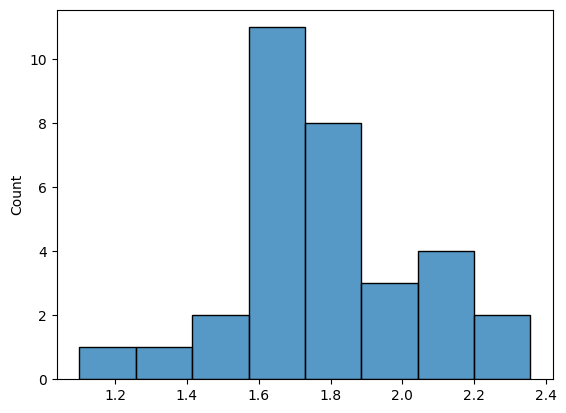

In [48]:
torch.linalg.norm(outp[batch][..., :2] - target_data[batch][..., :2], dim=1)

tensor([0.0050, 0.0101, 0.0172, 0.0271, 0.0407, 0.0581, 0.0799, 0.1062, 0.1372,
        0.1729, 0.2132, 0.2585, 0.3085, 0.3638, 0.4240, 0.4896, 0.5609, 0.6377,
        0.7203, 0.8083, 0.9021, 1.0012, 1.1051, 1.2140, 1.3274, 1.4454, 1.5672,
        1.6930, 1.8227, 1.9554, 2.0909, 2.2285, 2.3677, 2.5076, 2.6471, 2.7858,
        2.9226, 3.0568, 3.1873, 3.3134, 3.4343, 3.5488, 3.6559, 3.7545, 3.8436,
        3.9219, 3.9884, 4.0422, 4.0823, 4.1082, 4.1189, 4.1142, 4.0938, 4.0574,
        4.0054, 3.9380, 3.8565, 3.7620, 3.6567, 3.5434], device='cuda:1',
       grad_fn=<LinalgVectorNormBackward0>)

In [55]:
gpus = [f'cuda:{i}' for i in range(3)]
procs_per_gpu = 2

In [56]:
gpus*procs_per_gpu

['cuda:0', 'cuda:1', 'cuda:2', 'cuda:0', 'cuda:1', 'cuda:2']